[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/auhcheng/picodiffusion/blob/main/flowmatching.ipynb)

This notebook should run in less than 30 seconds on CPU.

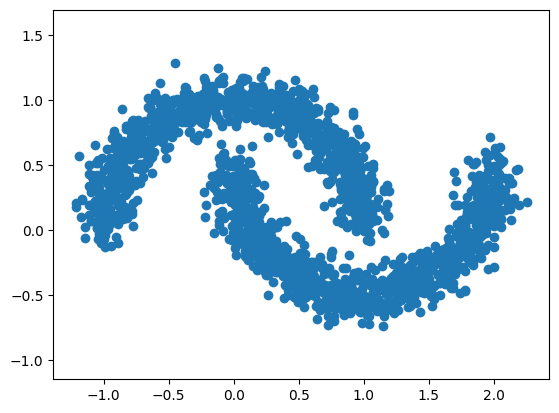

In [1]:
from sklearn.datasets import make_moons, make_circles
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt

# Generate the dataset
X, y = make_moons(n_samples=2000, noise=0.1, random_state=42)

# Plot the dataset
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

In [2]:
device = "cpu"
# device = "mps" # apple metal
# device = "cuda"

A flow matching model learns a time-dependent velocity field that transforms noise at $t=0$ to data at $t=1$.
i.e. How should the wind blow at every moment in time, so that it moves the initial random noise points to become data points?


## Training
We let $p_0(x_0)$ be a noise distribution that is easy to sample.
We define $p_1(x_1) \approx p_\mathrm{data}(x)$ to be approximately equal to our data distribution.
Then we define $p_t(x_t)$ to be linear interpolations of noise and data:
$$
x_t = (1-t)x_0 + t x_1
$$

Notice that the time derivative of $x_t$ (the velocity of the interpolant) is:
$$
\dot{x}_t = \frac{d}{dt}x_t = x_1 - x_0
$$

We use a neural network $v_\theta(x, t)$ with parameters $\theta$ to approximate the time-dependent velocity field.
This network can be trained by minimizing the "conditional flow matching loss":
$$
\mathcal{L}_{\mathrm{CFM}}(\theta) = \mathbb{E}_{x_0\sim p_0, x_1\sim p_1, t\sim U(0,1)}||v_\theta(x_t, t) - \dot{x}_t||^2
$$

This loss samples a random pair (noise, data) and a random time along the interpolation, and encourages the network to match the true velocity.
Intuitively, if the network has the correct velocity to transport a noise point to a data point for every pair (noise, data), then the network can transform the distribution $p_0$ into $p_1$.


## Sampling

Once the network is trained, how do we use it? We initialize $x \sim p_0(x)$, and then solve the following ordinary differential equation (ODE) from time $t=0$ until $t=1$:
$$
dx = v_\theta(x, t) dt
$$

In [3]:
def loss(net, batch):
    bsz = batch.shape[0]

    x0 = torch.randn(bsz, 2, device=device) # random noise
    x1 = batch # real data
    
    t = torch.rand(bsz, 1, device=device) # time ~ U(0, 1)

    # interpolate between x0 and x1
    xt = (1 - t) * x0 + t * x1

    # target is the velocity, the time-derivative of the interpolant
    target = x1 - x0

    pred = net(torch.cat([xt, t], dim=1))

    return torch.mean((pred - target) ** 2)

@torch.no_grad()
def sample(net, bsz):
    x0 = torch.randn(bsz, 2, device=device)

    num_steps = 200
    dt = 1 / num_steps

    x = x0
    t = torch.zeros(bsz, 1, device=device)
    traj = [x.clone().cpu().numpy()]

    # follow the velocity field
    for i in range(num_steps):
        vel = net(torch.cat([x, t], dim=1))
        x += vel * dt
        t += dt

        traj.append(x.clone().cpu().numpy())
    
    return x.cpu().numpy(), np.array(traj)

In [4]:
# define the neural network:
# 4-layer ReLU network with hidden dimension 512

d = 512
net = nn.Sequential(
    nn.Linear(3, d),
    nn.ReLU(),
    nn.Linear(d, d),
    nn.ReLU(),
    nn.Linear(d, d),
    nn.ReLU(),
    nn.Linear(d, 2),
).to(device)

Epoch 0, Loss: 1.5099021366664342


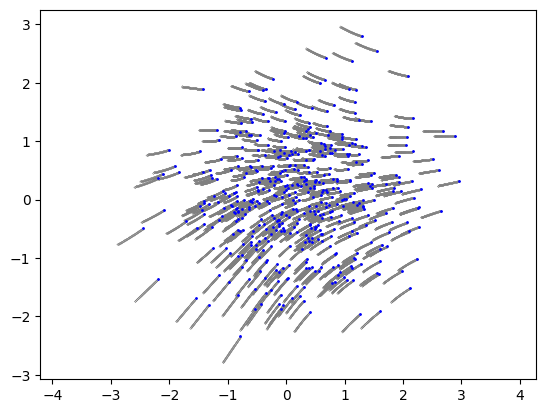

Epoch 100, Loss: 1.0611968295914787


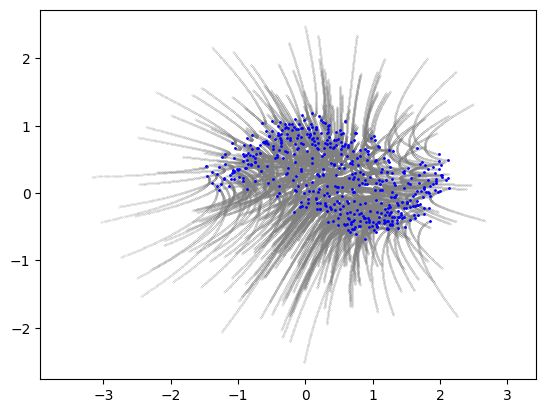

Epoch 200, Loss: 1.0405216217041016


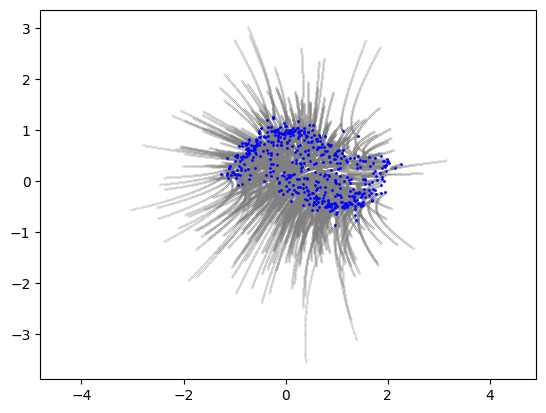

Epoch 300, Loss: 1.0485119819641113


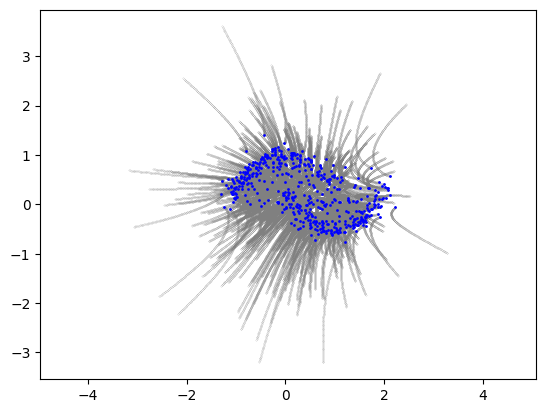

Epoch 400, Loss: 1.004082781927926


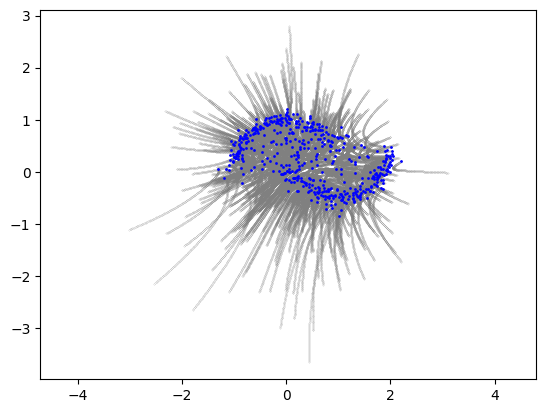

Epoch 500, Loss: 1.019226338182177


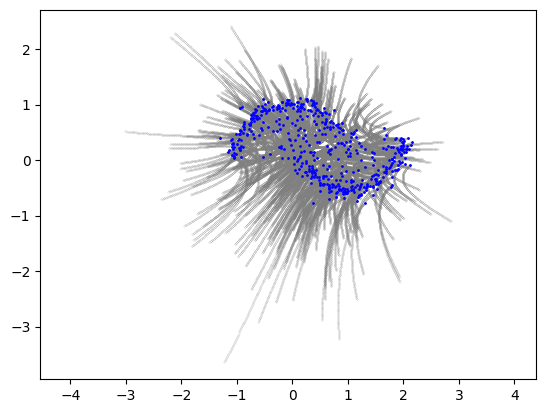

In [5]:
# training loop
opt = torch.optim.Adam(net.parameters(), lr=1e-4)

epochs = 500
vis_every_n_epochs = 100
bsz = 256  # batch size
num_batches = X.shape[0] // bsz

losses = []

for epoch in range(epochs+1):
    perm = torch.randperm(X.shape[0])
    epoch_loss = 0
    for i in range(num_batches):
        indices = perm[i * bsz:(i + 1) * bsz]
        batch = torch.tensor(X[indices], dtype=torch.float32, device=device)
        
        opt.zero_grad()
        l = loss(net, batch)
        l.backward()
        opt.step()
        
        epoch_loss += l.item()

    epoch_loss /= num_batches
    losses.append(epoch_loss)

    if epoch % vis_every_n_epochs == 0:
        print(f"Epoch {epoch}, Loss: {epoch_loss}")
        samples, traj = sample(net, 500)
        plt.scatter(traj.reshape(-1, 2)[:,0], traj.reshape(-1, 2)[:,1], s=0.01, color='grey')
        plt.plot(samples[:, 0], samples[:, 1], 'bo', markersize=1)
        plt.axis('equal')
        plt.show()

# each sampling trajectory from noise to data is in gray
# the blue dots are the samples from the learned distribution

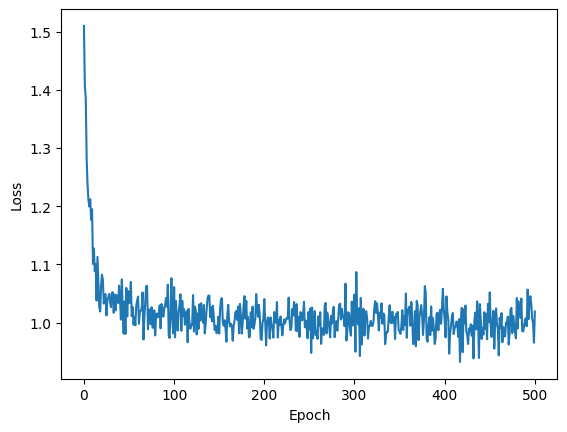

In [6]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss");

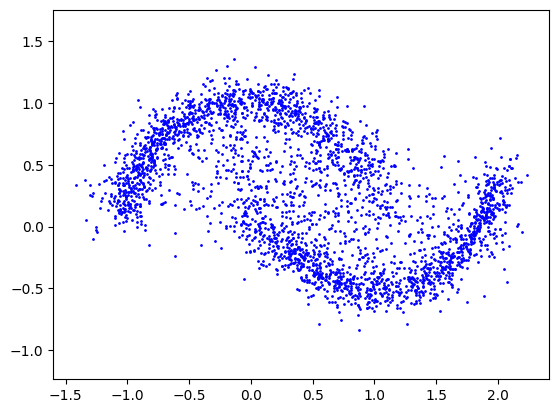

In [7]:
# generate some samples
samples, traj = sample(net, 3000)
plt.axis('equal')
plt.plot(samples[:, 0], samples[:, 1], 'bo', markersize=1);

# things you can try

- change the noise distribution to a gaussian with different mean and stdev
- make the model conditional on which moon it is by providing label `y` as an input to the neural network
- increase or decrease the size of the neural network
- increase or decrease training length
- try training with GPU on colab
- change the dataset to make_circles: `X, y = make_circles(n_samples=2000, noise=0.03, random_state=42, factor=0.5)`
- increase or decrease the number of steps used during sampling